# Imports

In [160]:
import SpotCurve.Spot_Curve_Calculator as sc
import matplotlib.pyplot as plt
import pandas as pd
import mpl_bsic
import importlib
import Returns.RollDown as rd
from Utils.data_processing import process_data
import Utils.CrossSectional_Regression as csr

importlib.reload(sc)
importlib.reload(rd)
importlib.reload(csr)

<module 'Utils.CrossSectional_Regression' from '/Users/vittoriomanfriani/PycharmProjects/backtesting series - episode 3/Utils/CrossSectional_Regression.py'>

# Load Data

In [141]:
data = pd.read_parquet('/Users/vittoriomanfriani/Desktop/BSIC/Datasets/bond_data_auction.parquet')
# take data only from 2010-01-01
data = data.loc[(data.index.get_level_values(0) >= '2010-01-01') & (data.index.get_level_values(0) <= '2024-10-02')]

# Apply Bootstrapper

In [142]:
spot_rates_calculator = sc.SpotRatesCalculator()

In [143]:
zero_curve_df = spot_rates_calculator.apply_bootstrapper(data,freq = 'tenors')

100%|██████████| 3847/3847 [00:50<00:00, 76.18it/s]


# Apply Nelson Siegel

In [144]:
loadings_df = spot_rates_calculator.apply_nelson_siegel(zero_curve_df, ridge=True)

100%|██████████| 3847/3847 [00:19<00:00, 198.34it/s]


In [145]:
loadings_df.head()

,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Lambda
Date,,,,
2010-01-01,5.450417,-5.660297,-1.629674,1.938934
2010-01-04,5.504185,-5.511876,-2.083122,1.955853
2010-01-05,5.478544,-5.636324,-1.929022,1.991484
2010-01-06,5.587564,-5.665702,-2.133468,1.996884
2010-01-07,5.560739,-5.816297,-1.779900,2.004868


## Interpolate with Nelson-Siegel-Svensonn

In [146]:
interpolated_curve_df = spot_rates_calculator.interpolate_nelson_siegel(loadings_df, freq = 'quarterly')

100%|██████████| 3847/3847 [00:03<00:00, 1019.23it/s]


In [147]:
interpolated_curve_df

,Curve,Maturities
Date,,
2010-01-01,-0.209879,0.00
2010-01-01,0.043386,0.25
2010-01-01,0.283784,0.50
2010-01-01,0.511783,0.75
2010-01-01,0.727874,1.00
...,...,...
2024-10-02,4.020506,29.00
2024-10-02,4.020506,29.25
2024-10-02,4.020506,29.50


### Plot and compare the two curves

adding fonts to font manager
base dir:  /Users/vittoriomanfriani/anaconda3/lib/python3.11/site-packages/mpl_bsic
fonts dir:  /Users/vittoriomanfriani/anaconda3/lib/python3.11/site-packages/mpl_bsic/fonts


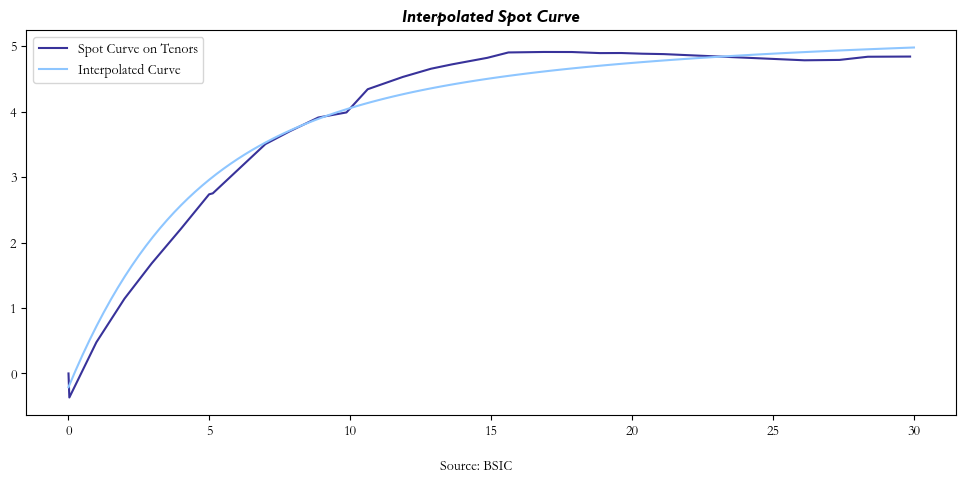

In [148]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(zero_curve_df.loc['2010-01-01', 'Maturities'], zero_curve_df.loc['2010-01-01','Curve'], label = 'Spot Curve on Tenors')
ax.plot(interpolated_curve_df.loc['2010-01-01', 'Maturities'], interpolated_curve_df.loc['2010-01-01','Curve'], label = 'Interpolated Curve')
ax.legend()
ax.set_title('Interpolated Spot Curve')
mpl_bsic.apply_bsic_style(fig, ax)


# Compute Returns

## Overall returns

In [149]:
# Function to compute returns
def compute_gross_returns(df):
    # Calculate daily coupons (coupon/365) and lagged price
    df.loc[:, 'daily_coupons'] = df['coupon'] / 365
    df.loc[:, 'prev_price'] = df.groupby('id')['price'].shift(1)  # Lagged price for each bond

    # Compute returns using the formula
    df.loc[:, 'returns'] = ((df['price'] + df['daily_coupons']) - df['prev_price']) / df['prev_price']

    return df

In [150]:
data = process_data(data)
data = compute_gross_returns(data)

# Carry

In [151]:
def compute_carry(df):
    df['carry'] = df['daily_coupons'] / df['prev_price']
    return df

In [152]:
data = compute_carry(data)

## RollDown

In [153]:
data = rd.compute_rolldown(data)

100%|█████████▉| 3846/3847 [07:10<00:00,  8.92it/s]


## Excess returns

In [154]:
data['Excess Returns'] = data['returns'] - data['carry'] - data['rolldown']

# Cross Sectional Regression

In [161]:
params = csr.cross_sectional_regression_nelson_siegel(data, loadings_df)

 61%|██████▏   | 2361/3847 [00:04<00:02, 572.43it/s]/Users/vittoriomanfriani/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/vittoriomanfriani/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/vittoriomanfriani/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/vittoriomanfriani/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/vittoriomanfriani/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **k

In [162]:
params.iloc[:2000].mean()

date         2013-11-03 09:14:24
const                   0.000552
beta1                    0.00044
beta2                  -0.003739
r_squared               0.666732
dtype: object

In [163]:
loadings_df

,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Lambda
Date,,,,
2010-01-01,5.450417,-5.660297,-1.629674,1.938934
2010-01-04,5.504185,-5.511876,-2.083122,1.955853
2010-01-05,5.478544,-5.636324,-1.929022,1.991484
2010-01-06,5.587564,-5.665702,-2.133468,1.996884
2010-01-07,5.560739,-5.816297,-1.779900,2.004868
...,...,...,...,...
2024-09-26,4.042284,-3.688100,0.000495,0.000006
2024-09-27,3.999927,-3.649409,0.001052,0.000013
2024-09-30,4.020360,-3.668191,-0.000567,-0.000005


In [81]:
data.tail(30)

coupon maturity_date     yield      price  \
timestamp  id                                                        
2024-10-02 US91282CLL36   3.375    2027-09-15  3.547000  99.519531   
           US91282CLM19   3.625    2031-09-30  3.647000  99.867188   
           US91282CLN91   3.500    2029-09-30  3.554000  99.753906   
           US91282CLP40   3.500    2026-09-30  3.636000  99.740234   
2024-10-03 US912828Y958   1.875    2026-07-31  5.608974  96.746094   
2024-10-04 US912828Y958   1.875    2026-07-31  5.647515  96.390625   
2024-10-07 US912828Y958   1.875    2026-07-31  5.660619  96.271484   
2024-10-08 US912828Y958   1.875    2026-07-31  5.669593  96.335938   
2024-10-09 US912828Y958   1.875    2026-07-31  5.682346  96.242188   
2024-10-10 US912828Y958   1.875    2026-07-31  5.690465  96.353516   
2024-10-11 US912828Y958   1.875    2026-07-31  5.722732  96.376953   
2024-10-14 US912828Y958   1.875    2026-07-31  5.733911  96.376953   
2024-10-15 US912828Y958   1.875    2026-07-31  5.744895  96.390625   
2024-10-16 US912828Y958   1.875    2026-07-31  5.755775  96.414062   
2024-10-17 US912828Y958   1.875    2026-07-31  5.768511  96.363281   
2024-10-18 US912828Y958   1.875    2026-07-31  5.802566  96.421875   
2024-10-21 US912828Y958   1.875    2026-07-31  5.817656  96.292969   
2024-10-22 US912828Y958   1.875    2026-07-31  5.829861  96.292969   
2024-10-23 US912828Y958   1.875    2026-07-31  5.844039  96.214844   
2024-10-24 US912828Y958   1.875    2026-07-31  5.856239  96.226562   
2024-10-25 US912828Y958   1.875    2026-07-31  5.895101  96.201172   
2024-10-28 US912828Y958   1.875    2026-07-31  5.909159  96.158203   
2024-10-29 US912828Y958   1.875    2026-07-31  5.920760  96.224609   
2024-10-30 US912828Y958   1.875    2026-07-31  5.937067  96.099609   
2024-10-31 US912828Y958   1.875    2026-07-31  5.949890  96.126953   
2024-11-01 US912828Y958   1.875    2026-07-31  5.992257  96.083984   
2024-11-04 US912828Y958   1.875    2026-07-31  6.004602  96.156250   
2024-11-05 US912828Y958   1.875    2026-07-31  6.019502  96.128906   
2024-11-06 US912828Y958   1.875    2026-07-31  6.036694  96.013672   
2024-11-07 US912828Y958   1.875    2026-07-31  6.048938  96.109375   

                         time to maturity issue_date  rolldown  daily_coupons  \
timestamp  id                                                                   
2024-10-02 US91282CLL36          2.951403 2024-09-16 -0.000033       0.009247   
           US91282CLM19          6.992471 2024-09-30 -0.000019       0.009932   
           US91282CLN91          4.993840 2024-09-30 -0.000110       0.009589   
           US91282CLP40          1.993155 2024-09-30 -0.000006       0.009589   
2024-10-03 US912828Y958          1.823409 2019-07-31  0.000062       0.005137   
2024-10-04 US912828Y958          1.820671 2019-07-31 -0.000043       0.005137   
2024-10-07 US912828Y958          1.812457 2019-07-31 -0.000047       0.005137   
2024-10-08 US912828Y958          1.809719 2019-07-31 -0.000048       0.005137   
2024-10-09 US912828Y958          1.806982 2019-07-31 -0.000048       0.005137   
2024-10-10 US912828Y958          1.804244 2019-07-31 -0.000049       0.005137   
2024-10-11 US912828Y958          1.801506 2019-07-31 -0.000048       0.005137   
2024-10-14 US912828Y958          1.793292 2019-07-31 -0.000049       0.005137   
2024-10-15 US912828Y958          1.790554 2019-07-31 -0.000049       0.005137   
2024-10-16 US912828Y958          1.787817 2019-07-31 -0.000049       0.005137   
2024-10-17 US912828Y958          1.785079 2019-07-31 -0.000049       0.005137   
2024-10-18 US912828Y958          1.782341 2019-07-31 -0.000050       0.005137   
2024-10-21 US912828Y958          1.774127 2019-07-31 -0.000050       0.005137   
2024-10-22 US912828Y958          1.771389 2019-07-31 -0.000051       0.005137   
2024-10-23 US912828Y958          1.768652 2019-07-31 -0.000051       0.005137   
2024-10-24 US912828Y958          1.765914 2019-07-31 -0.000052       0.005137   
20

In [133]:
params[3280:]

,date,const,beta1,beta2,r_squared
3280,2022-08-08,0.004745,3.784818e-02,-1.071736e-01,0.125987
3281,2022-08-09,-0.001069,-2.050969e-03,9.404474e-03,0.007488
3282,2022-08-10,-0.000417,-7.349326e-03,2.054749e-02,0.005936
3283,2022-08-11,-0.006608,-1.934127e-02,9.225499e-02,0.072772
3284,2022-08-12,0.003472,1.049762e-02,-7.151223e-02,0.070719
...,...,...,...,...,...
3646,2024-09-23,0.000000,2.994618e-238,-1.584580e-235,-4.086480
3647,2024-09-24,0.001386,-2.733609e-01,-2.733609e-01,0.014001
3648,2024-09-25,0.000000,2.263856e-284,-1.441954e-281,-7.484970
3649,2024-09-26,-0.000413,6.658176e-01,6.658176e-01,0.000846


In [137]:
loadings_df[3281:]

,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Lambda
Date,,,,
2022-08-02,3.044665,-2.767009,-0.000232,0.025845
2022-08-03,2.995912,-2.724001,-0.000077,0.015275
2022-08-04,3.015879,-2.798402,-0.002225,0.075519
2022-08-05,3.150822,-3.060572,-0.003743,0.095157
2022-08-08,3.056314,-2.779159,-0.000145,0.020287
...,...,...,...,...
2024-09-26,4.042284,-3.688100,0.000495,0.000006
2024-09-27,3.999927,-3.649409,0.001052,0.000013
2024-09-30,4.020360,-3.668191,-0.000567,-0.000005


In [139]:
data.loc['2022-08-17']

,coupon,maturity_date,yield,price,time to maturity,issue_date,daily_coupons,prev_price,returns,carry,rolldown,Excess Returns
id,,,,,,,,,,,,
US912810EN47,7.625,2022-11-15,2.537,101.210938,0.246407,1992-11-16,0.020890,101.222656,0.000091,0.000206,0.000254,-0.000369
US912810EP94,7.125,2023-02-15,2.741,102.126953,0.498289,1993-05-17,0.019521,102.130859,0.000153,0.000191,-0.000219,0.000181
US912810EQ77,6.250,2023-08-15,3.116,103.037109,0.993840,1994-02-15,0.017123,103.039062,0.000147,0.000166,-0.000808,0.000789
US912810ES34,7.500,2024-11-15,3.254,109.101562,2.247775,1994-08-15,0.020548,109.226562,-0.000956,0.000188,-0.000800,-0.000345
US912810ET17,7.625,2025-02-15,3.292,110.285156,2.499658,1995-02-15,0.020890,110.460938,-0.001402,0.000189,-0.000258,-0.001334
...,...,...,...,...,...,...,...,...,...,...,...,...
US91282CFA45,3.000,2024-07-31,3.286,99.462891,1.954825,2022-08-01,0.008219,99.507812,-0.000369,0.000083,-0.000017,-0.000435
US91282CFB28,2.750,2027-07-31,3.052,98.621094,4.952772,2022-08-01,0.007534,99.062500,-0.004380,0.000076,-0.000151,-0.004304
US91282CFC01,2.625,2029-07-31,2.990,97.726562,6.954141,2022-08-01,0.007192,98.335938,-0.006124,0.000073,-0.000019,-0.006178
